# Multi-Armed Bandit Algorithms Comparison

In this Jupyter Notebook, we will compare different multi-armed bandit algorithms on a two-armed bandit problem. The following algorithms will be used:

1. Bayesian Thompson Sampling
2. UCB (Upper Confidence Bound)
3. Epsilon-Greedy



## Environment Setup and Imports

Let's start by importing the required libraries and setting up the environment.


In [4]:
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
plt.style.use('seaborn-white')

# Define utility functions
def pplot(ax=None):
    if ax is None:
        plt.grid(True, alpha=0.5)
        axoff(plt.gca())
    else:
        ax.grid(True, alpha=0.5)
        axoff(ax)
    return

def axoff(ax, keys=['top', 'right']):
    for k in keys:
        ax.spines[k].set_visible(False)
    return

## Bandit Environment and Algorithm Classes

Next, let's define the BanditEnvironment class and the classes for different bandit algorithms.


In [5]:
class BanditEnvironment:
    def __init__(self, num_arms, true_rewards):
        self.num_arms = num_arms
        self.true_rewards = true_rewards

    def pull_arm(self, arm):
        reward = self.true_rewards[arm] + NOISE_STD * np.random.randn()
        return reward

In [6]:

class UCB:
    def __init__(self, num_arms):
        self.num_arms = num_arms
        self.arm_counts = np.zeros(num_arms)
        self.arm_rewards = np.zeros(num_arms)
        self.time_step = 0
    
    def select_arm(self):
        if self.time_step < self.num_arms:
            return self.time_step
        ucb_values = self.arm_rewards / self.arm_counts + np.sqrt(2 * np.log(self.time_step) / self.arm_counts)
        return np.argmax(ucb_values)
    
    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.arm_rewards[arm] += reward
        self.time_step += 1


class EpsilonGreedy:
    def __init__(self, num_arms, epsilon):
        self.num_arms = num_arms
        self.epsilon = epsilon
        self.arm_counts = np.zeros(num_arms)
        self.arm_rewards = np.zeros(num_arms)
        self.time_step = 0
    
    def select_arm(self):
        if np.random.rand() < self.epsilon:
            return np.random.randint(self.num_arms)
        return np.argmax(self.arm_rewards / self.arm_counts)
    
    def update(self, arm, reward):
        self.arm_counts[arm] += 1
        self.arm_rewards[arm] += reward
        self.time_step += 1


#### %%%%%%% YOU WILL EDIT THIS CELL AT SOME POINT %%%%%%% 

In [7]:
class BayesianThompsonSampling:
    def __init__(self, num_arms, prior_means, prior_variances, arm_noise_variances):
        self.num_arms = num_arms
        self.prior_means = prior_means
        self.prior_variances = prior_variances
        self.arm_noise_variances = arm_noise_variances
    
    def select_arm(self):
        arm_samples = np.random.normal(self.prior_means, np.sqrt(self.prior_variances))
        return np.argmax(arm_samples)

    def update(self, arm, reward):
        posterior_precision = 1.0 / self.prior_variances[arm] + 1.0 / self.arm_noise_variances[arm]
        posterior_mean = (self.prior_means[arm] / self.prior_variances[arm] + reward / self.arm_noise_variances[arm]) / posterior_precision
        self.prior_means[arm] = posterior_mean
        self.prior_variances[arm] = 1.0 / posterior_precision

class BayesianThompsonSamplingV2:
    def __init__(self, num_arms, prior_means, prior_variances, arm_noise_variances):
        self.num_arms = num_arms
        self.prior_means = prior_means
        self.prior_variances = prior_variances
        self.arm_noise_variances = arm_noise_variances

    def select_arm(self):
        '''IMPLEMENT THIS CODE. Your code should involve computing some probability and then generating
        the arm directly. Your code should return the probability of sampling arm 1, and the sampled arm.'''
    
    def update(self, arm, reward):
        '''IMPLEMENT THIS CODE to update the means and variance in Thompson sampling.
         Your code should involve updating some mean and variances; and loading them back in
         self.prior_means and self.prior_variances'''


## Algorithm Comparison

Now, let's compare the performance of different algorithms in the bandit environment.


#### %%%%%%% YOU WILL EDIT THIS CELL AT SOME POINT %%%%%%% 

In [8]:

# np.random.seed(1000)
np.random.seed(100)
EVAL_BTS = True # CHANGE THIS TO True when you finish EXERCISE 1 / Editing BTS code.
EVAL_BTSV2 = False # CHANGE THIS TO True when you finish EXERCISE 2 / Editing BTSV2 code.
## %%%%%%% UNTIL HERE %%%%%%% 

NUM_ARMS  = 2
TRUE_REWARDS = np.array([1., 0])
NOISE_STD = 1.
NOISE_STD_EST = 1.
assert(len(TRUE_REWARDS)==NUM_ARMS)



In [9]:
# Parameters
num_arms = 2
num_rounds = 1000
prior_means = np.zeros(num_arms) 
prior_variances = np.ones(num_arms)
arm_noise_variances = NOISE_STD_EST**2 * np.ones(num_arms)
epsilon = 0.1

# Create Bandit environment
bandit_env = BanditEnvironment(num_arms=NUM_ARMS, true_rewards=TRUE_REWARDS)
true_rewards = bandit_env.true_rewards
optimal_reward = np.max(bandit_env.true_rewards)
optimal_arm = np.argmax(bandit_env.true_rewards)

# Create algorithms
ucb = UCB(num_arms)
eps_greedy = EpsilonGreedy(num_arms, epsilon)

# Create a list of algorithms
algs = [
    ('UCB', ucb),
    ('EpsilonGreedy', eps_greedy)
]
if EVAL_BTS:
    bts = BayesianThompsonSampling(num_arms, prior_means, prior_variances, arm_noise_variances)
    algs.append(('Bayes. Thomp. Sampling', bts))
if EVAL_BTSV2:
    btsv2 = BayesianThompsonSamplingV2(num_arms, prior_means, prior_variances, arm_noise_variances)
    algs.append(('Bayes. Thomp. Sampling V2', btsv2))
    p_bts2 = np.zeros(num_rounds) # probabilities of selecting arm

# Create an empty dictionary to store results for each algorithm
results = {alg: {
    'chosen_arms': np.zeros(num_rounds, dtype=int),
    'rewards': np.zeros(num_rounds),
    'cumulative_rewards': np.zeros(num_rounds),
    'cumulative_regret': np.zeros(num_rounds),
    'cumulative_pulls': np.zeros(num_rounds)
} for alg, _ in algs}

for t in range(num_rounds):
    for alg, alg_obj in algs:
        # Select arm and pull it
        if alg == "Bayes. Thomp. Sampling V2":
            p_bts2[t], chosen_arm = alg_obj.select_arm()
        else:
            chosen_arm = alg_obj.select_arm()
        reward = bandit_env.pull_arm(chosen_arm)
        regret = optimal_reward-true_rewards[chosen_arm]

        # Update algorithm
        alg_obj.update(chosen_arm, reward)
        
        # Store results in the dictionary
        results[alg]['chosen_arms'][t] = chosen_arm
        results[alg]['rewards'][t] = reward
        results[alg]['cumulative_rewards'][t] = results[alg]['cumulative_rewards'][t-1] + reward if t>0 else reward
        results[alg]['cumulative_regret'][t] = results[alg]['cumulative_regret'][t-1] + regret if t>0 else regret
        results[alg]['cumulative_pulls'][t] = (results[alg]['cumulative_pulls'][t-1]*t+(chosen_arm==optimal_arm))/(t+1) if t>0 else chosen_arm==optimal_arm


/var/folders/nt/c8zq1h1s6dsfk8_kn9nkbvgwq9j3yw/T/ipykernel_12107/582382791.py:31: RuntimeWarning: invalid value encountered in true_divide
  return np.argmax(self.arm_rewards / self.arm_counts)


# Plot cumulative rewards, cumulative regret, and number of pulls for each algorithm


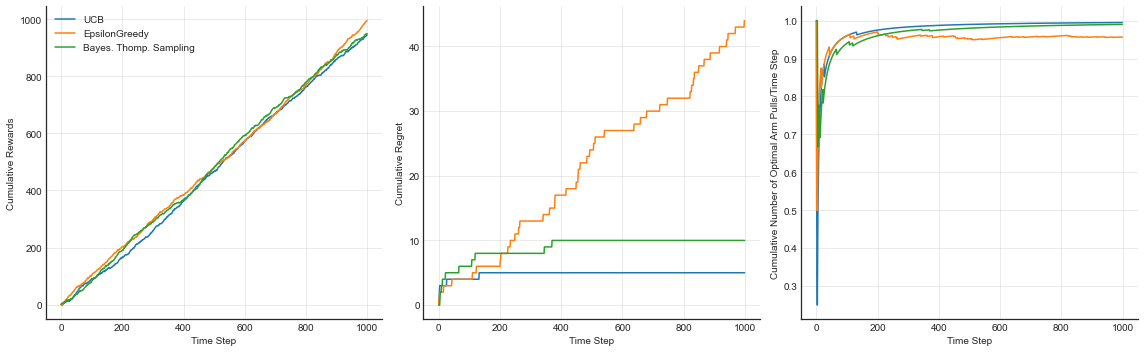

In [10]:
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
axs = axs.flatten()

for alg, data in results.items():
    axs[0].plot(range(num_rounds), data['cumulative_rewards'], label=alg)
    axs[1].plot(range(num_rounds), data['cumulative_regret'], label=alg)
    axs[2].plot(range(num_rounds), data['cumulative_pulls'], label=alg)

axs[0].set_ylabel("Cumulative Rewards")
axs[0].legend()

axs[1].set_ylabel("Cumulative Regret")

axs[2].set_ylabel("Cumulative Number of Optimal Arm Pulls/Time Step")

for j in range(3):
    axs[j].set_xlabel("Time Step")
    pplot(axs[j])
plt.tight_layout()
plt.show()



## Questions

1. What would happen to the regrets of different algorithms if we:
   - Reduce the separation between the two arms?
   - Increase noise variance in rewards?
   - Noise variance estimate was wrong?
   - Increase the number of rounds?
2. BONUS: Try to empirically check the scaling rate of regret with the number of decision times using a Log-scale and least squares fit.
3. Play around with random seeds and other problem parameters. Try something fun and creative. If you find something interesting, share it with us!